In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
img = cv2.imread("horse.png", cv2.IMREAD_GRAYSCALE)
_, binary = cv2.threshold(img, 127, 1, cv2.THRESH_BINARY_INV)

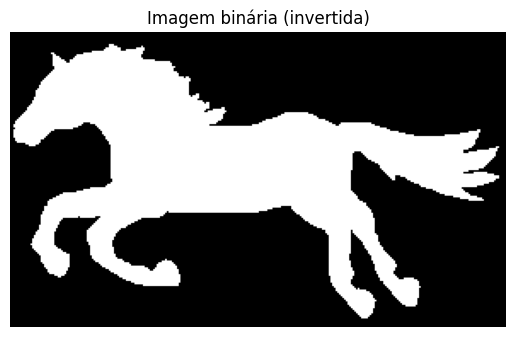

In [3]:
plt.imshow(binary, cmap='gray')
plt.title("Imagem binária (invertida)")
plt.axis('off')
plt.show()

In [4]:
#ESQUELETONIZAÇÃO

def skeletonize(img_bin):
    skel = np.zeros_like(img_bin)
    element = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
    img = img_bin.copy()

    while True:
        eroded = cv2.erode(img, element)
        opened = cv2.dilate(eroded, element)
        temp = cv2.subtract(img, opened)
        skel = cv2.bitwise_or(skel, temp)
        img = eroded.copy()
        if cv2.countNonZero(img) == 0:
            break

    return skel

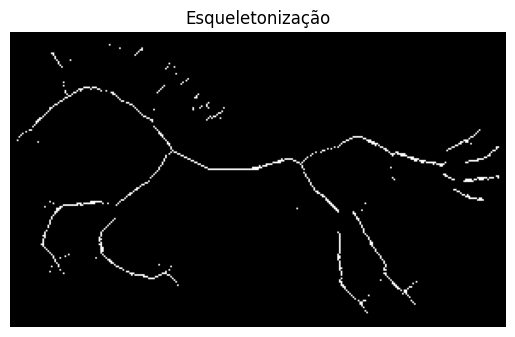

In [5]:
skeleton = skeletonize(binary)

plt.imshow(skeleton, cmap='gray')
plt.title("Esqueletonização")
plt.axis('off')
plt.show()

In [6]:
#RECONSTRUÇÃO MORFOLÓGICA - DILATAÇÃO GEODÉSICA

def geodesic_dilation(marker, mask, kernel=None, iterations=1):
    if kernel is None:
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    for _ in range(iterations):
        marker = cv2.dilate(marker, kernel)
        marker = np.minimum(marker, mask)
    return marker

In [7]:
#RECONSTRUÇÃO POR DILATAÇÃO

def reconstruction_by_dilation(marker, mask, kernel=None):
    prev = np.zeros_like(marker)
    curr = marker.copy()
    while not np.array_equal(curr, prev):
        prev = curr.copy()
        curr = geodesic_dilation(curr, mask, kernel)
    return curr

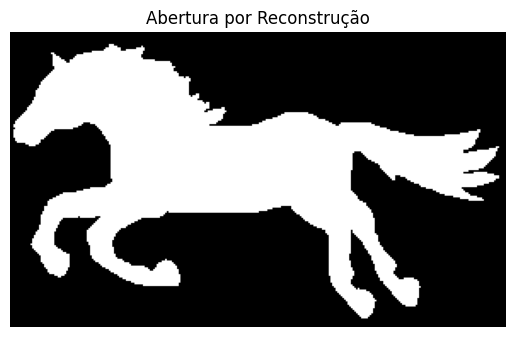

In [8]:
#ABERTURA POR RECONSTRUÇÃO

def opening_by_reconstruction(img_bin, kernel=None, iterations=1):
    if kernel is None:
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    eroded = cv2.erode(img_bin, kernel, iterations=iterations)
    opened = reconstruction_by_dilation(eroded, img_bin, kernel)
    return opened

opened_reconstruction = opening_by_reconstruction(binary)

plt.imshow(opened_reconstruction, cmap='gray')
plt.title("Abertura por Reconstrução")
plt.axis('off')
plt.show()

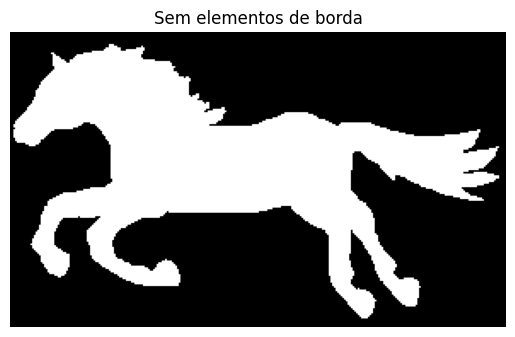

In [9]:
#ELIMINAÇÃO DE ELEMENTOS DE BORDA

def clear_border(img_bin):
    marker = np.zeros_like(img_bin)
    marker[0, :] = img_bin[0, :]
    marker[-1, :] = img_bin[-1, :]
    marker[:, 0] = img_bin[:, 0]
    marker[:, -1] = img_bin[:, -1]
    marker = reconstruction_by_dilation(marker, img_bin)
    return img_bin - marker

sem_borda = clear_border(binary)

plt.imshow(sem_borda, cmap='gray')
plt.title("Sem elementos de borda")
plt.axis('off')
plt.show()